### **Credit Scoring Model**

Random Forest Accuracy: 0.82
Random Forest ROC AUC: 0.724486116119726
              precision    recall  f1-score   support

           0       0.83      0.49      0.62        59
           1       0.82      0.96      0.88       141

    accuracy                           0.82       200
   macro avg       0.82      0.72      0.75       200
weighted avg       0.82      0.82      0.80       200

XGBoost Accuracy: 0.79
XGBoost ROC AUC: 0.717994951316264
              precision    recall  f1-score   support

           0       0.68      0.54      0.60        59
           1       0.82      0.89      0.86       141

    accuracy                           0.79       200
   macro avg       0.75      0.72      0.73       200
weighted avg       0.78      0.79      0.78       200

Best Model Accuracy: 0.785
Best Model ROC AUC: 0.7045918980646713
              precision    recall  f1-score   support

           0       0.68      0.51      0.58        59
           1       0.81      0.90      0.86

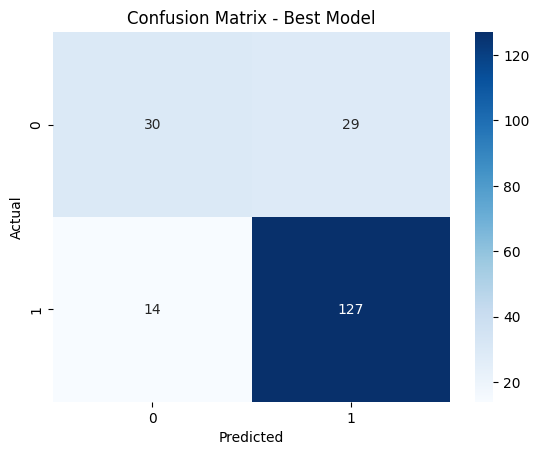

Predicted Credit Risk: 1


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
data_path = '/content/sample_data/GermanCredit.csv'  # Update with the correct path to your dataset
data = pd.read_csv(data_path)

# Ensure there are no leading/trailing spaces in column names
data.columns = data.columns.str.strip()

# Define the target variable and features
target_column = 'credit_risk'
if target_column not in data.columns:
    raise KeyError(f"Column '{target_column}' not found in the DataFrame")

X = data.drop(target_column, axis=1)
y = data[target_column]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline for numerical data
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

# Train the Random Forest model
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_pipeline.fit(X_train, y_train)

# Predict and evaluate the Random Forest model
y_pred_rf = rf_pipeline.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC AUC:", roc_auc_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Train the XGBoost model
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

xgb_pipeline.fit(X_train, y_train)

# Predict and evaluate the XGBoost model
y_pred_xgb = xgb_pipeline.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost ROC AUC:", roc_auc_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# Hyperparameter Tuning for XGBoost
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Predict and evaluate the best model
y_pred_best = best_model.predict(X_test)
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("Best Model ROC AUC:", roc_auc_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))
print("Best Model Parameters:", grid_search.best_params_)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix:\n", conf_matrix)

# Display the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Model')
plt.show()

# Function to predict credit risk based on user input
def predict_credit_risk(input_data):
    # Create a DataFrame from the input data
    input_df = pd.DataFrame([input_data])

    # Ensure the input columns match the training data
    missing_cols = set(X.columns) - set(input_df.columns)
    for col in missing_cols:
        input_df[col] = np.nan

    # Reorder columns to match the training data
    input_df = input_df[X.columns]

    # Predict using the best model
    prediction = best_model.predict(input_df)
    return prediction[0]

# Example usage
example_input = {
    'status': 'no checking account',
    'duration': 24,
    'credit_history': 'existing credits paid back duly till now',
    'purpose': 'domestic appliances',
    'amount': 3430,
    'savings': '500 <= ... < 1000 DM',
    'employment_duration': '... >= 7 years',
    'installment_rate': 3,
    'personal_status_sex': 'male : single',
    'other_debtors': 'none',
    'present_residence': 2,
    'property': 'car or other',
    'age': 31,
    'other_installment_plans': 'none',
    'housing': 'own',
    'number_credits': 1,
    'job': 'skilled employee/official',
    'people_liable': 2,
    'telephone': 'yes',
    'foreign_worker': 'yes'
}

prediction = predict_credit_risk(example_input)
print(f"Predicted Credit Risk: {prediction}")
